In [ ]:
!pip install scikeras

In [ ]:
import keras
import joblib
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, make_scorer
from keras.layers import Input, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, LeakyReLU
from keras.models import Model, load_model
from keras.callbacks import EarlyStopping
from keras.utils import plot_model

import warnings
warnings.filterwarnings('ignore')

# Importing model and preparing Inputs

In [ ]:
np.random.seed(1)
tf.random.set_seed(1)

num_classes = 6

In [ ]:
import urllib.request
import zipfile
# ZIP data URL from GitHub
zip_url = "https://github.com/NelloArchives/DL/raw/main/input_data.zip"
# Download the ZIP
zip_path, _ = urllib.request.urlretrieve(zip_url)
# Unzip the folder
target_folder = "temp"
# reading data
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(target_folder)
data_path = f"{target_folder}/input_data.pkl"

In [ ]:
target_folder = "temp"
data_path = f"{target_folder}/input_data.pkl"
#Then use the following lines to read it:
import pickle as pk
with open(data_path, 'rb') as f:
    dd = pk.load(f)

imgs = dd['imgs']
masks = dd['masks']

## Brief Analysis of the dataset

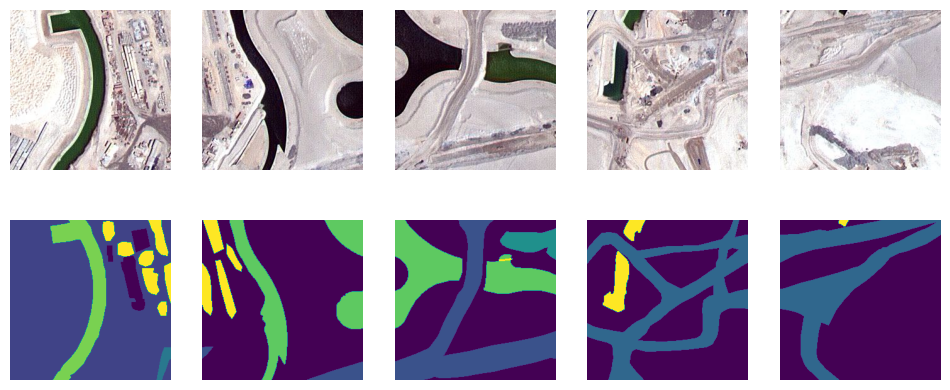

In [ ]:
def plot_example(imgs, masks, num_images=5):
    plt.figure(figsize=(12, 5))
    for i in range(num_images):
        plt.subplot(2, num_images, i + 1)
        plt.imshow(imgs[i])
        plt.axis('off')
        plt.subplot(2, num_images, i + num_images + 1)
        plt.imshow(masks[i])
        plt.axis('off')
    plt.show()

# Example usage
plot_example(imgs, masks, num_images=5)

In [ ]:
print(imgs.shape, masks.shape)

(1305, 256, 256, 3) (1305, 256, 256, 1)


Due to memory constraints, I will use only a small subset of the data.

In [ ]:
imgs, _, masks, _ = train_test_split(
    imgs, masks, test_size=0.6, random_state=42
)

print("Images shape:", imgs.shape)
print("Masks shape:", masks.shape)

Images shape: (522, 256, 256, 3)
Masks shape: (522, 256, 256, 1)


## Splitting The Data

In [ ]:
imgs_train, imgs_test, masks_train, masks_test = train_test_split(
    imgs, masks, test_size=0.2, random_state=42
)

print("Training images shape:", imgs_train.shape)
print("Testing images shape:", imgs_test.shape)
print("Training masks shape:", masks_train.shape)
print("Testing masks shape:", masks_test.shape)

Training images shape: (417, 256, 256, 3)
Testing images shape: (105, 256, 256, 3)
Training masks shape: (417, 256, 256, 1)
Testing masks shape: (105, 256, 256, 1)


# **(1-2-3-4-5a-5b-5c) MODEL, INPUT, OUTPUT, LOSS, MODEL CONFIGURATION**
## Defining the model

The below is a wrapper to make it possible to use GridSearchCV from scikit-learn

the function ```build_model``` is structured as follow:
- preprocessing
- encoding with ```Conv2D``` and ```MaxPooling2d```
- decoding with ```Conv2DTranspose``` and ```Conv2d```, each time concatenation with corresponding encoding layer is done with ```concatenate```
- output layer shape=(256,256,6), activation = 'softmax'
- model compilation with loss = "sparse_categorical_crossentropy" and Adam optimizer

build_model can create models with different numbers on layers depending on the amount parameter passed

In [ ]:
class KerasImageSegmentationModel(BaseEstimator, ClassifierMixin):
    def __init__(self,
                 lr = 0.001,
                 filters = [8, 15, 21, 30],
                 filtersize = 3,
                 stride = 2,
                 epochs = 10,
                 batch_size = 8):

        self.lr = lr
        self.filters = filters
        self.filtersize = filtersize
        self.stride = stride
        self.epochs = epochs
        self.classes_ = np.arange(6)
        self.batch_size = batch_size
        self.model = self.build_model(lr, filters, filtersize, stride)

    def build_model(self, lr, filters, filtersize, stride):

        n_layers = len(filters)
        inputs = Input(shape = (256,256,3))

        s = Lambda(lambda x: x / 255) (inputs) # 2a - INPUT PREPROCESSING

        # Encoder
        conv_layers = []
        x = s
        for i in range(n_layers):
            x = Conv2D(filters[i], (filtersize, filtersize),  kernel_initializer='he_normal', padding='same')(x)
            x = LeakyReLU(negative_slope=0.1)(x)
            x = Conv2D(filters[i], (filtersize, filtersize), kernel_initializer='he_normal', padding='same')(x)
            x = LeakyReLU(negative_slope=0.1)(x)
            conv_layers.append(x)
            if i < n_layers - 1:
                x = MaxPooling2D((stride, stride))(x)

        # Decoder
        for i in range(n_layers - 2, -1, -1):
            x = Conv2DTranspose(filters[i], (stride, stride), strides=(stride,stride), padding='same')(x)
            x = concatenate([x, conv_layers[i]])
            x = Conv2D(filters[i], (filtersize, filtersize), kernel_initializer='he_normal', padding='same')(x)
            x = LeakyReLU(negative_slope=0.1)(x)
            x = Conv2D(filters[i], (filtersize, filtersize), kernel_initializer='he_normal', padding='same')(x)
            x = LeakyReLU(negative_slope=0.1)(x)

        x = Conv2D(1, filtersize, padding='same')(x)
        x = LeakyReLU(negative_slope=0.1)(x)
        outputs = Conv2D(6, 1, padding='valid', activation='softmax')(x) # 3 - OUTPUT

        model = Model(inputs=[inputs], outputs=[outputs])
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=lr),
                loss="sparse_categorical_crossentropy", # 4 - LOSS
                metrics=["accuracy"]
        )

        return model

    def fit(self, X, y, validation_data=None, callbacks=None):
        history = self.model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, verbose=2, validation_data=validation_data, callbacks=callbacks)
        return history

    def predict(self, X):
        return self.model.predict(X)

In [ ]:
model = KerasImageSegmentationModel()
model.model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 256, 256, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 8)    │            224 │ lambda[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu (LeakyReLU)   │ (None, 256, 256, 8)    │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 8)    │            584 │ leaky_re_lu[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_1 (LeakyReLU) │ (None, 256, 256, 8)    │              0 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 8)    │              0 │ leaky_re_lu_1[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 15)   │          1,095 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_2 (LeakyReLU) │ (None, 128, 128, 15)   │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 15)   │          2,040 │ leaky_re_lu_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_3 (LeakyReLU) │ (None, 128, 128, 15)   │              0 │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 15)     │              0 │ leaky_re_lu_3[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 21)     │          2,856 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_4 (LeakyReLU) │ (None, 64, 64, 21)     │              0 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 21)     │          3,990 │ leaky_re_lu_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_5 (LeakyReLU) │ (None, 64, 64, 21)     │              0 │ conv2d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 32, 32, 21)     │              0 │ leaky_re_lu_5[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 32, 32, 30)     │          5,700 │ max_pooling2d_2[0][0]  │
├──────────────────────

 Total params: 48,806 (190.65 KB)

 Trainable params: 48,806 (190.65 KB)

 Non-trainable params: 0 (0.00 B)

# HyperParameter Tuning

## Metrics Used

The below functions are custom functions to compute the equivalent of accuracy and f1 scores on image segmentation tasks:
- They both take the predicted masks and ground truth and flatten them going from (batch_size,256,256,1) -> (batch_size\*256\*256,1)
- then they compute the ```f1_score``` and ```accuracy_score``` on the two resulting vectors
- finally they are wrapped with ```make_scorer``` to be able to use them in ```GridSearchCV```

```accuracy_forImages``` is the equivalent of the mean pixel accuracy for each image
```f1_forImages``` will return on average lower scores since it treats each class equally due to average = "macro"

In [ ]:
def f1_forImages(y_true, y_pred):

    y_pred = np.argmax(y_pred, axis=-1) #from probabilities to integers

    # Flatten the arrays to shape (batch_size * height * width,)
    y_true_flat = np.reshape(y_true, [-1])
    y_pred_flat = np.reshape(y_pred, [-1])

    f1 = f1_score(y_true_flat, y_pred_flat, average="macro") # to evaluate each class equally

    return f1


def accuracy_forImages(y_true, y_pred):

    y_pred = np.argmax(y_pred, axis=-1)

    y_true_flat = np.reshape(y_true, [-1])
    y_pred_flat = np.reshape(y_pred, [-1])

    acc = accuracy_score(y_true_flat, y_pred_flat)

    return acc

f1_scorer = make_scorer(f1_forImages, greater_is_better=True)
acc_scorer = make_scorer(accuracy_forImages, greater_is_better=True)

## GridSearchCV

Below I perform a grid search on the following hyperparameters:
- learning rate
- batch size
- number of layers and hidden units
- filter sizes

### **CHANGE:** due to RAM and time limitations I had to remove the hypertuning on stride

In [ ]:
model = KerasImageSegmentationModel()

#similar number of parameters is maintained across these configurations

filters = [[8, 12, 16, 20, 24], #51,061 parameters
           [8, 15, 21, 30]] # 48,806 parameters

filtersize = [5,7]
stride = [2]
lr = [0.001, 0.0001]
batchsizes = [16, 32]

param_grid = {

    "filters": filters,
    "lr": lr,
    "filtersize": filtersize,
    "stride": stride,
    "batch_size": batchsizes
}

In [ ]:
gs = GridSearchCV(estimator=model, param_grid=param_grid,
                  n_jobs=1,
                  scoring=f1_scorer, # using the custom scorer only here since it slows down the grid search if appli
                  error_score="raise",
                  cv=2,
                  verbose=3)


grid_result = gs.fit(imgs_train, masks_train)

Fitting 2 folds for each of 16 candidates, totalling 32 fits
Epoch 1/10
13/13 - 37s - 3s/step - accuracy: 0.3972 - loss: 1.6704
Epoch 2/10
13/13 - 14s - 1s/step - accuracy: 0.5521 - loss: 1.4986
Epoch 3/10
13/13 - 1s - 89ms/step - accuracy: 0.5522 - loss: 1.4053
Epoch 4/10
13/13 - 1s - 97ms/step - accuracy: 0.5551 - loss: 1.3326
Epoch 5/10
13/13 - 1s - 64ms/step - accuracy: 0.5586 - loss: 1.2698
Epoch 6/10
13/13 - 1s - 64ms/step - accuracy: 0.5678 - loss: 1.2358
Epoch 7/10
13/13 - 1s - 96ms/step - accuracy: 0.5783 - loss: 1.2124
Epoch 8/10
13/13 - 1s - 63ms/step - accuracy: 0.5860 - loss: 1.1912
Epoch 9/10
13/13 - 1s - 63ms/step - accuracy: 0.5903 - loss: 1.1744
Epoch 10/10
13/13 - 1s - 96ms/step - accuracy: 0.5907 - loss: 1.1561
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 607ms/step
[CV 1/2] END batch_size=16, filters=[8, 12, 16, 20, 24], filtersize=5, lr=0.001, stride=2;, score=0.207 total time= 1.3min
Epoch 1/10
14/14 - 14s - 975ms/step - accuracy: 0.4742 - loss: 1.7833
Epoch 2/10
14/14 - 2s - 116

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step
[CV 1/2] END batch_size=16, filters=[8, 12, 16, 20, 24], filtersize=5, lr=0.0001, stride=2;, score=0.137 total time=  31.3s
Epoch 1/10
14/14 - 11s - 781ms/step - accuracy: 0.5121 - loss: 1.5092
Epoch 2/10
14/14 - 4s - 312ms/step - accuracy: 0.5121 - loss: 1.4016
Epoch 3/10
14/14 - 1s - 83ms/step - accuracy: 0.5121 - loss: 1.3380
Epoch 4/10
14/14 - 1s - 59ms/step - accuracy: 0.5121 - loss: 1.3199
Epoch 5/10
14/14 - 1s - 59ms/step - accuracy: 0.5120 - loss: 1.3023
Epoch 6/10
14/14 - 1s - 89ms/step - accuracy: 0.5110 - loss: 1.2606
Epoch 7/10
14/14 - 1s - 90ms/step - accuracy: 0.5117 - loss: 1.2099
Epoch 8/10
14/14 - 1s - 59ms/step - accuracy: 0.5115 - loss: 1.1963
Epoch 9/10
14/14 - 1s - 59ms/step - accuracy: 0.5160 - loss: 1.1825
Epoch 10/10
14/14 - 1s - 60ms/step - accuracy: 0.5260 - loss: 1.1907


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step
[CV 2/2] END batch_size=16, filters=[8, 12, 16, 20, 24], filtersize=5, lr=0.0001, stride=2;, score=0.132 total time=  29.2s
Epoch 1/10
13/13 - 9s - 686ms/step - accuracy: 0.1394 - loss: 1.9632
Epoch 2/10
13/13 - 2s - 117ms/step - accuracy: 0.1482 - loss: 1.7800
Epoch 3/10
13/13 - 1s - 63ms/step - accuracy: 0.2637 - loss: 1.7711
Epoch 4/10
13/13 - 1s - 63ms/step - accuracy: 0.5258 - loss: 1.7622
Epoch 5/10
13/13 - 1s - 96ms/step - accuracy: 0.5521 - loss: 1.7532
Epoch 6/10
13/13 - 1s - 63ms/step - accuracy: 0.5521 - loss: 1.7444
Epoch 7/10
13/13 - 1s - 96ms/step - accuracy: 0.5521 - loss: 1.7357
Epoch 8/10
13/13 - 1s - 64ms/step - accuracy: 0.5521 - loss: 1.7270
Epoch 9/10
13/13 - 1s - 96ms/step - accuracy: 0.5521 - loss: 1.7184
Epoch 10/10
13/13 - 1s - 65ms/step - accuracy: 0.5521 - loss: 1.7096
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step
[CV 1/2] END batch_size=16, filters=[8, 12, 16, 20, 24], filtersize=7, lr=0.001, stride=2;, score=0.113 total time=

### Results of the GridSearchCV

In [ ]:
print("Best: %f using %s" % (grid_result.best_score_,
                             grid_result.best_params_))

best_params = gs.best_params_

Best: 0.263727 using {'batch_size': 16, 'filters': [8, 15, 21, 30], 'filtersize': 7, 'lr': 0.0001, 'stride': 2}


## EarlyStopping
Below I'm using early stopping to understand the number of epochs that my model needs until validation loss stops decreasing

In [ ]:
imgs_train_new, imgs_val, masks_train_new, masks_val = train_test_split(
    imgs_train, masks_train, test_size=0.2, random_state=42
)

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=15,
                               verbose=1,
                               restore_best_weights=True)


best_model = KerasImageSegmentationModel(**best_params, epochs= 100)
best_model.fit(imgs_train_new, masks_train_new, validation_data=(imgs_val, masks_val), callbacks=[early_stopping])

Epoch 1/100
21/21 - 62s - 3s/step - accuracy: 0.2187 - loss: 1.7873 - val_accuracy: 0.3217 - val_loss: 1.6865
Epoch 2/100
21/21 - 29s - 1s/step - accuracy: 0.4309 - loss: 1.6004 - val_accuracy: 0.5032 - val_loss: 1.5159
Epoch 3/100
21/21 - 5s - 223ms/step - accuracy: 0.5351 - loss: 1.4720 - val_accuracy: 0.5067 - val_loss: 1.4792
Epoch 4/100
21/21 - 4s - 183ms/step - accuracy: 0.5392 - loss: 1.4239 - val_accuracy: 0.5080 - val_loss: 1.3948
Epoch 5/100
21/21 - 4s - 186ms/step - accuracy: 0.5517 - loss: 1.3277 - val_accuracy: 0.5557 - val_loss: 1.3122
Epoch 6/100
21/21 - 5s - 243ms/step - accuracy: 0.6084 - loss: 1.2277 - val_accuracy: 0.6160 - val_loss: 1.1908
Epoch 7/100
21/21 - 5s - 259ms/step - accuracy: 0.6160 - loss: 1.2003 - val_accuracy: 0.6177 - val_loss: 1.1887
Epoch 8/100
21/21 - 5s - 227ms/step - accuracy: 0.6182 - loss: 1.1841 - val_accuracy: 0.6195 - val_loss: 1.1717
Epoch 9/100
21/21 - 5s - 257ms/step - accuracy: 0.6139 - loss: 1.1789 - val_accuracy: 0.6200 - val_loss: 1.1

## Final Training
Now that I have determined the best number of epochs I will train on both train and validation.

I will also monitor the validation accuracy on the test data only to plot the learning curve later.

**No** tuning will be effected on the test data during this step.

In [ ]:
tf.random.set_seed(26)

best_epochs = early_stopping.best_epoch
best_model = KerasImageSegmentationModel(**best_params, epochs = best_epochs)
history = best_model.fit(imgs_train, masks_train, validation_data=(imgs_test, masks_test))

Epoch 1/95
27/27 - 24s - 875ms/step - accuracy: 0.1964 - loss: 1.7831 - val_accuracy: 0.2726 - val_loss: 1.7534
Epoch 2/95
27/27 - 5s - 187ms/step - accuracy: 0.2349 - loss: 1.7570 - val_accuracy: 0.1737 - val_loss: 1.7299
Epoch 3/95
27/27 - 5s - 181ms/step - accuracy: 0.1970 - loss: 1.7380 - val_accuracy: 0.1681 - val_loss: 1.6970
Epoch 4/95
27/27 - 5s - 180ms/step - accuracy: 0.1887 - loss: 1.6939 - val_accuracy: 0.1643 - val_loss: 1.6609
Epoch 5/95
27/27 - 5s - 181ms/step - accuracy: 0.1904 - loss: 1.6500 - val_accuracy: 0.1704 - val_loss: 1.6298
Epoch 6/95
27/27 - 5s - 179ms/step - accuracy: 0.1887 - loss: 1.6328 - val_accuracy: 0.1678 - val_loss: 1.6143
Epoch 7/95
27/27 - 5s - 180ms/step - accuracy: 0.1902 - loss: 1.6187 - val_accuracy: 0.1625 - val_loss: 1.6032
Epoch 8/95
27/27 - 5s - 179ms/step - accuracy: 0.1952 - loss: 1.6066 - val_accuracy: 0.1641 - val_loss: 1.5886
Epoch 9/95
27/27 - 5s - 187ms/step - accuracy: 0.1970 - loss: 1.5964 - val_accuracy: 0.1695 - val_loss: 1.5788


# **6 - MODEL EVALUATION**

In [ ]:
train_preds = best_model.predict(imgs_train)
test_preds = best_model.predict(imgs_test)

14/14 ━━━━━━━━━━━━━━━━━━━━ 14s 164ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 353ms/step


## Looking at some Prediction

Given the resource limitations the model could predict some of the mask almost correctly

However, sometimes the prediction are completely off

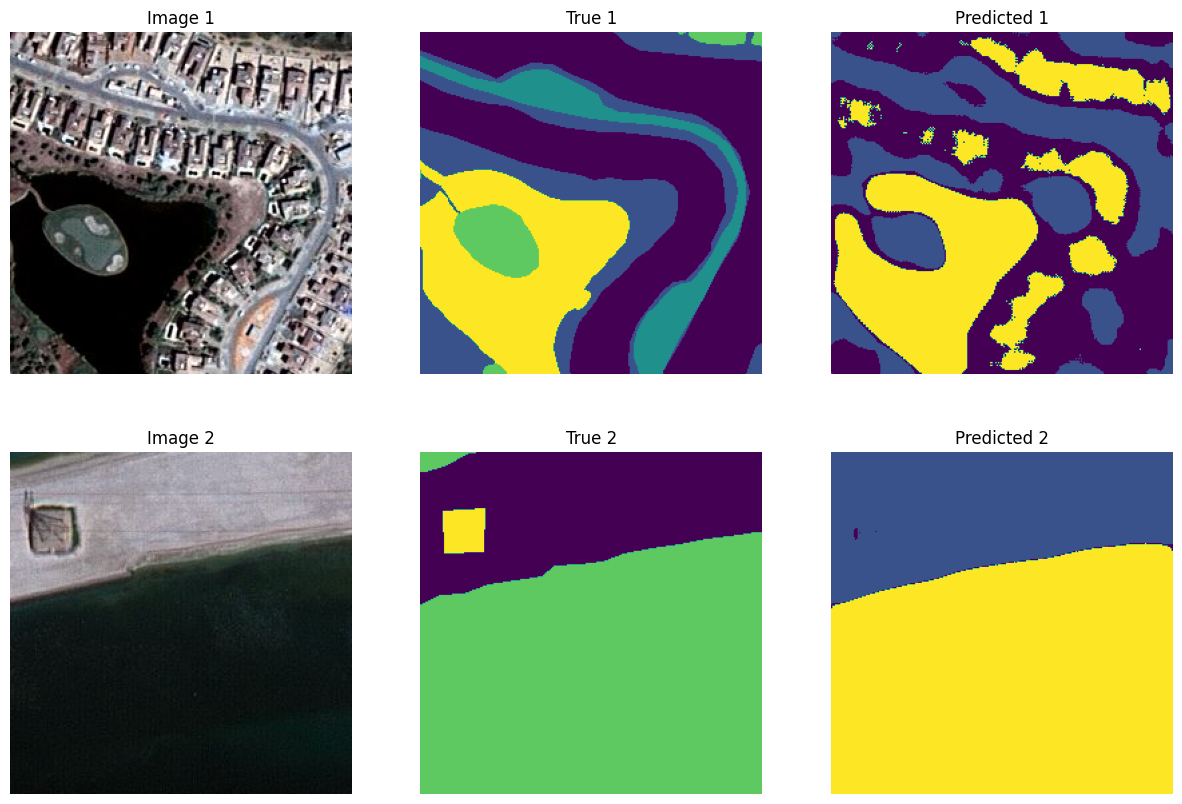

In [ ]:
th_pred = np.argmax(test_preds, axis=-1)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))


i1 = 32
i2 = 64

axes[0, 0].imshow(imgs_test[i1])
axes[0, 0].set_title("Image 1")
axes[0, 0].axis('off')

axes[0, 1].imshow(masks_test[i1])
axes[0, 1].set_title("True 1")
axes[0, 1].axis('off')

axes[0, 2].imshow(th_pred[i1])
axes[0, 2].set_title("Predicted 1")
axes[0, 2].axis('off')

axes[1, 0].imshow(imgs_test[i2])
axes[1, 0].set_title("Image 2")
axes[1, 0].axis('off')

axes[1, 1].imshow(masks_test[i2])
axes[1, 1].set_title("True 2")
axes[1, 1].axis('off')

axes[1, 2].imshow(th_pred[i2])
axes[1, 2].set_title("Predicted 2")
axes[1, 2].axis('off')

plt.show()


## Scores on test and train data

I initially guessed that applying dropout and L2 regularization might hinder the learning of critical patterns because of the task's complexity. Therefore, I decided not to apply them and the model showed no signs of overfitting.

In [ ]:
print("Test Set Results")
print(f"f1_score: {f1_forImages(masks_test,test_preds)}")
print(f"accuracy score: {accuracy_forImages(masks_test,test_preds)}")

print("\nTrain Set Results")
print(f"f1_score: {f1_forImages(masks_train,train_preds)}")
print(f"accuracy score: {accuracy_forImages(masks_train,train_preds)}")

Test Set Results
f1_score: 0.37117145572218724
accuracy score: 0.6999574207124256

Train Set Results
f1_score: 0.3706943805604174
accuracy score: 0.7015774953279564


## Learning Curve

The learning curves suggest that the model can still learn more, as indicated by the ongoing improvements in accuracy and reductions in loss beyond the initial epochs.

Also, the curves suggest that a more complex model could be beneficial, as the current model is still learning without overfitting much.

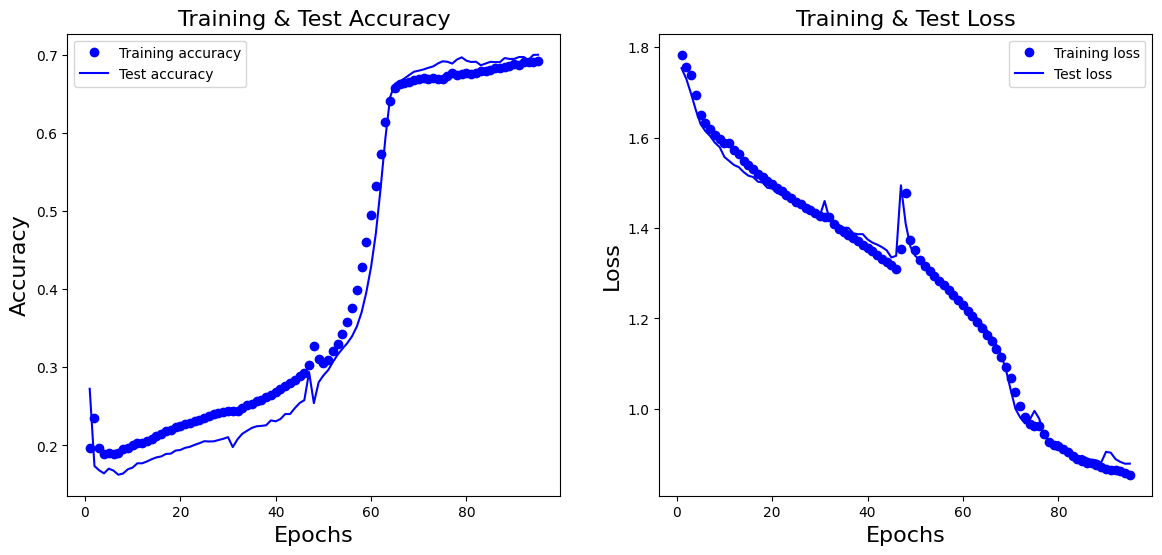

In [ ]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

epochs = range(1, len(loss_values) + 1)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
#
# Plot the model accuracy vs Epochs
#
ax[0].plot(epochs, accuracy, 'bo', label='Training accuracy')
ax[0].plot(epochs, val_accuracy, 'b', label='Test accuracy')
ax[0].set_title('Training & Test Accuracy', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=16)
ax[0].set_ylabel('Accuracy', fontsize=16)
ax[0].legend()
#
# Plot the loss vs Epochs
#
ax[1].plot(epochs, loss_values, 'bo', label='Training loss')
ax[1].plot(epochs, val_loss_values, 'b', label='Test loss')
ax[1].set_title('Training & Test Loss', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=16)
ax[1].set_ylabel('Loss', fontsize=16)
ax[1].legend()